In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM,Dense,BatchNormalization,Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('../data/one_feature_data.csv')
data.shape

(3809, 1)

In [3]:
data.head()

,Open
0,49.813286
1,50.316402
2,55.168217
3,55.412300
4,52.284027


### Train, Val, Test spliting

In [4]:
train_org = data.iloc[:3048,:]
test = data.iloc[3048:,:]
train_org.shape, test.shape   

((3048, 1), (761, 1))

In [5]:
scaler = MinMaxScaler()
train_org = scaler.fit_transform(train_org)
test = scaler.transform(test)

In [6]:
train = train_org[:2287, :]
val = train_org[2287:, :]
train.shape, val.shape                     # train: 2287 seqs, val: 761 seqs, test: 761 seqs

((2287, 1), (761, 1))

In [7]:
X_train=[]
y_train=[]

for i in range(0,train.shape[0]-31):         # idea: use 30 previous day to predict next 1 day
    X_train.append(train[i:i+30,:])
    y_train.append(train[i+30:i+31,:])

X_train,y_train=np.array(X_train),np.array(y_train)
X_train.shape,y_train.shape

((2256, 30, 1), (2256, 1, 1))

In [8]:
X_val=[]
y_val=[]

for i in range(0,val.shape[0]-31):         # idea: use 30 previous day to predict next 1 day
    X_val.append(val[i:i+30,:])
    y_val.append(val[i+30:i+31,:])

X_val,y_val=np.array(X_val),np.array(y_val)
X_val.shape,y_val.shape

((730, 30, 1), (730, 1, 1))

In [9]:
X_test=[]
y_test=[]

for i in range(0,test.shape[0]-31):         # idea: use 30 previous day to predict next 1 day
    X_test.append(test[i:i+30,:])
    y_test.append(test[i+30:i+31,:])

X_test,y_test=np.array(X_test),np.array(y_test)
X_test.shape,y_test.shape

((730, 30, 1), (730, 1, 1))

### Modeling

In [10]:
model = Sequential()

model.add(LSTM(units=16, activation='tanh', return_sequences=False,
               input_shape=(X_train.shape[1], X_train.shape[2])))

# model.add(BatchNormalization())  BN is useless in RNN
# model.add(Dropout(0.2))   Dropout in RNN will destroy memory, use recurrent_dropout param in LSTM instead

model.add(Dense(1))

In [11]:
model.summary()
# 1152=4*(16*1+16**2+16)   # 16 lstm units, 1 feature, 4 is constant for lstm unit, 3 for gru

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [12]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='mean_squared_error')

In [13]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

Train on 2256 samples, validate on 730 samples
Epoch 1/30
2256/2256 [==============================] - 5s 2ms/sample - loss: 0.0144 - val_loss: 0.0066
Epoch 2/30
2256/2256 [==============================] - 0s 211us/sample - loss: 8.1416e-04 - val_loss: 0.0033
Epoch 3/30
2256/2256 [==============================] - 0s 203us/sample - loss: 4.4554e-04 - val_loss: 0.0028
Epoch 4/30
2256/2256 [==============================] - 0s 207us/sample - loss: 3.8559e-04 - val_loss: 0.0019
Epoch 5/30
2256/2256 [==============================] - 0s 208us/sample - loss: 3.4209e-04 - val_loss: 0.0010
Epoch 6/30
2256/2256 [==============================] - 0s 208us/sample - loss: 2.9500e-04 - val_loss: 0.0012
Epoch 7/30
2256/2256 [==============================] - 0s 214us/sample - loss: 2.6925e-04 - val_loss: 0.0016
Epoch 8/30
2256/2256 [==============================] - 1s 223us/sample - loss: 2.4552e-04 - val_loss: 0.0020
Epoch 9/30
2256/2256 [==============================] - 0s 214us/sample - loss:

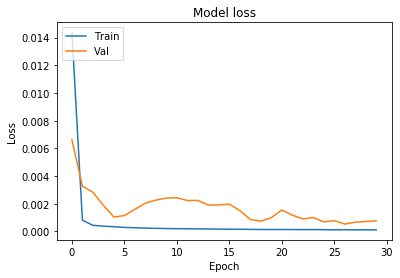

In [14]:
epoch_range=range(1,50+1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.xticks([x for x in range(epoch+1)])
plt.legend(['Train','Val'],loc='upper left')
plt.show()

### Evaluation

In [15]:
y_pred = model.predict(X_test)
y_pred.shape

(730, 1)

In [16]:
y_pred = scaler.inverse_transform(y_pred)
y_pred.shape

(730, 1)

In [17]:
scale = scaler.scale_[0]
scale

0.0013565203795903229

In [18]:
bias = scaler.min_[0]
bias

-0.06702540200800232

In [19]:
y_test = (y_test-bias)/scale

In [20]:
y_test = y_test.reshape(730, 1)

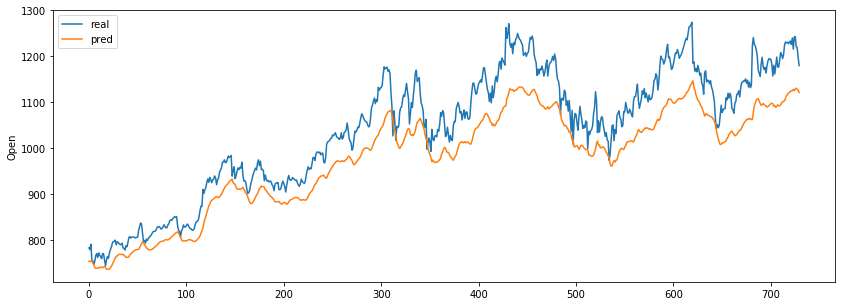

In [21]:
plt.figure(figsize=(14,5))
plt.plot(y_test,label='real')
plt.plot(y_pred,label='pred')
plt.ylabel('Open')
plt.legend()
plt.show()

In [22]:
model.save('../model/LSTM_seq2vec.h5')